In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize

AUCTS_SHORT = ["VCG", "WMS-Zero", "VCG-Direct", "WMS-Direct", "VCG-UB", "WMS-UB", "VCG-Reserve", "VCG-Reserve-UB"]
AUCTIONS = ["Vcg_ZeroPassengerCost", "WeightedMaxMinSurplus_ZeroPassengerCost",
            "Vcg_Fixed(100)", "WeightedMaxMinSurplus_Fixed(100)",
         "Vcg_FixedUpperBound", "WeightedMaxMinSurplus_FixedUpperBound", "VcgReserve_Reserve", "VcgReserve_ReserveUpperBound"]

def auct_for_auct_short(auct_short):
    return AUCTIONS[AUCTS_SHORT.index(auct_short)]


def auct_short_for_auct(auct):
    return AUCTS_SHORT[AUCTIONS.index(auct.replace("_brute", ""))]

def frame_for(dir, auction):
    return pd.read_json(open("ridesharing-solver/output/" + dir + "/" + auction + ".json"), dtype={'graph_name': str})


def vcg_frame_for_auct(dir, auction):
    data = frame_for(reference)
    del data['winning_ride']
    welfare = {}
    profit = {}
    for i, row in data.iterrows():
        welfare[str(data['graph_name'])] = data['welfare']
        profit[str(data['graph_name'])] = data['profit']
    return welfare, profit

def frame_for_auct(dir, auction):
    data = frame_for(dir, auction)
    vcg_frame = frame_for(dir, "Vcg_ZeroPassengerCost")
    del data['winning_ride']
    del data['graph_name']
    del vcg_frame['winning_ride']
    del vcg_frame['graph_name']

    data['profit'] /= vcg_frame['welfare']
    data['cost_profit'] /= vcg_frame['welfare']
    data['virtual_profit'] = data['profit'] - data['cost_profit']
    data['ratio'] = data['cost_profit'] / data['profit']
    data['welfare'] /= vcg_frame['welfare']
    data['virtual_welfare'] /= vcg_frame['welfare']
    
    # Brute force records running time in cents of second.
    if 'brute' in auction or auction ==  'VcgReserve_ReserveUpperBound':
        data['running_time'] /= 100.0
    
    return data

def aggregate_frame_for_auct(dir, auction):
    data = frame_for_auct(dir, auction)
    data = data.iloc[:,:].agg(['mean', 'std']).round(2)
    data = data.apply(lambda c: str(c['mean']) + " $\pm$ " + str(c['std']),  axis=0)
    data = data.to_frame().transpose()
    return data
    
def pretty_row_for(dir, auction):
    data = aggregate_frame_for_auct(dir, auction)
    data['Auction'] = auct_short_for_auct(auction)
    data['Brute Time (s)'] = aggregate_frame_for_auct(dir, auction + "_brute")['running_time']
    data = data.loc[:, ['Auction', 'profit', 'welfare', 'virtual_welfare', 'cost_profit', 'virtual_profit', "ratio", 'n_pass', 'running_time', 'Brute Time (s)']]
    data = data.rename(index=str, columns={"running_time": "ILP Time (s)", "profit": "Profit", "welfare": "Welfare", "n_pass": "Passengers",
                                           "virtual_welfare": "Virt. Welfare", "virtual_profit": "Virt. Profit"})
    return data

Auction           Profit          Welfare    Virt. Welfare    cost_profit  \
0  WMS-Zero  0.79 $\pm$ 0.08  0.95 $\pm$ 0.05  0.95 $\pm$ 0.05  0.0 $\pm$ 0.0   

      Virt. Profit          ratio      Passengers          ILP Time (s)  \
0  0.79 $\pm$ 0.08  0.0 $\pm$ 0.0  2.0 $\pm$ 0.14  3959.5 $\pm$ 6353.58   

    Brute Time (s)  
0  0.07 $\pm$ 0.05

In [22]:
def profile(dir, metric, aucts_short=AUCTS_SHORT):
    auctions = [auct_for_auct_short(auct_short) for auct_short in aucts_short]
    frames = [frame_for_auct(dir, auct) for auct in auctions]
    n_instances = len(frames[0])
    per_inst = [[frames[j][metric].iloc[i] for j in range(len(auctions))] for i in range(n_instances)]
    
    # Remove winners of size one, no significant effect.
    #n_pass_per_inst = [[frames[j]['n_pass'].iloc[i] for j in range(len(auctions))] for i in range(n_instances)]
    #for i in reversed(range(len(per_inst))):
    #    if n_pass_per_inst[i][0] == 1:
    #        del per_inst[i]
            
    max_metric = [max(metric) for metric in per_inst]
    to_remove = []
    for i in range(len(max_metric)):
        if max_metric[i] == 0:
            to_remove.append(i)
    for i in sorted(to_remove, reverse=True):
        del max_metric[i]
        del per_inst[i]

    per_inst = [[val/max_metric[i] for val in per_inst[i]] for i in range(len(per_inst))]
    per_auct = np.transpose(per_inst)
    for i in range(len(auctions)):
        label = AUCTS_SHORT[AUCTIONS.index(auctions[i])]
        plt.hist(per_auct[i], len(per_inst), range=(0, max(per_auct[i])), histtype="step", cumulative=-1, label=label)
    plt.legend(loc="lower left")
    plt.ylabel("no. of instances")
    plt.xlabel("ratio of maximum " + metric)
    plt.show()

In [23]:
import statistics

def count_wins(dir, metric, auction_a, auction_b):
    frame_a = frame_for_auct(dir, auction_a)
    frame_b = frame_for_auct(dir, auction_b)
    n_instances = len(frame_a[metric])
    a_instance_values = [frame_a[metric].iloc[i] for i in range(n_instances)]
    b_instance_values = [frame_b[metric].iloc[i] for i in range(n_instances)]
    a_vs_b = zip(a_instance_values, b_instance_values)
    
    a_wins = []
    b_wins = []
    a_de_zero = 0
    b_de_zero = 0
    ties = 0
    both_zero = 0
    for (a_val, b_val) in a_vs_b:
        if a_val > b_val:
            if b_val == 0 or a_val / b_val > 10:
                a_de_zero += 1
            else:
                a_wins.append(a_val / b_val)
        elif b_val > a_val:
            if a_val == 0 or b_val / a_val > 10:
                b_de_zero += 1
            else:
                b_wins.append(b_val / a_val)
        elif a_val == 0:
            both_zero += 1
        else:
            ties += 1
    plt.boxplot([a_wins, b_wins], labels=["a_wins", "b_wins"])
    plt.show()
    
    result = {}
    result['a_wins'] = len(a_wins) / n_instances
    result['a_de_zero'] = a_de_zero / n_instances
    result['a_avg'] = statistics.mean(a_wins)
    result['b_wins'] = len(b_wins) / n_instances
    result['b_de_zero'] = b_de_zero / n_instances
    result['b_avg'] = statistics.mean(b_wins)
    result['ties'] = ties / n_instances
    result['both_zero'] = both_zero / n_instances
    return pd.DataFrame.from_dict(result, orient='index')

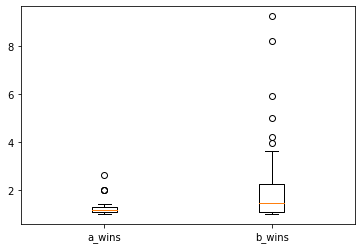

0
a_wins     0.290000
a_de_zero  0.000000
a_avg      1.293435
b_wins     0.360000
b_de_zero  0.090000
b_avg      2.270976
ties       0.260000
both_zero  0.000000

In [24]:
count_wins("10_3", "virtual_profit", "Vcg_FixedUpperBound", "WeightedMaxMinSurplus_FixedUpperBound")

In [ ]:
from fractions import Fraction
def calc_harmonic(n):
    return sum(Fraction(1, d) for d in range(1, n + 1))

def theoretical_virtual_welfare(dir, vcg_auct, wms_auct):
    vcg_frames = frame_for_auct(dir, vcg_auct)
    wms_frames = frame_for_auct(dir, wms_auct)
    res = {'theoretical': [], 'real': []}
    for ((_a, vcg_frame), (_b,wms_frame)) in zip(vcg_frames.iterrows(), wms_frames.iterrows()):
        n_pass = int(vcg_frame['n_pass'])
        if n_pass == 0:
            continue
        theoretical = 1 / float(calc_harmonic(n_pass))
        real = wms_frame['virtual_welfare'] / vcg_frame['virtual_welfare']
        res['theoretical'].append(theoretical)
        res['real'].append(real)
        if real < theoretical:
            print(vcg_frame)
            print(wms_frame)
            print(real)
            print(theoretical)
            raise Exception("theoretical guarantee violated")
    #pd.set_option('display.max_rows', 1000)
    frame = pd.DataFrame.from_dict(res)
    frame['ratio'] = frame['real'] / frame['theoretical']
    return frame['ratio'].mean()

In [ ]:
theoretical_virtual_welfare("10_2", "Vcg_FixedUpperBound", "WeightedMaxMinSurplus_FixedUpperBound")

In [ ]:
profile("10_3", "virtual_profit", 
        ["Vcg_FixedUpperBound", "WeightedMaxMinSurplus_FixedUpperBound"],
          ["VCG-UB", "WMS-UB"])

In [7]:
def table(dir):
    return pd.concat([pretty_row_for(dir, auct) for auct in AUCTIONS])

def table_paper(dir):
    table = pd.concat([pretty_row_for(dir, auct) for auct in AUCTIONS])
    del table['ratio']
    del table['cost_profit']
    return table

def boxblot(dir):
    data = table(dir)
    metrics = ['profit', 'virtual_profit']
    for metric in metrics:
        rows = []
        plt.figure()
        for auct in AUCTIONS:
            rows.append(row_for(dir, auct)[metric])
        plt.title(metric)
        plt.boxplot(rows, labels=AUCTS_SHORT)
    plt.show()

def latexify(table):
    latex = table.to_latex(index=False)
    return latex.replace('\\$\\textbackslash pm\\$', '$\\pm$')
    return latex

In [17]:
print(latexify(table_paper("10_3")))
print(latexify(table_paper("10_5")))
print(latexify(table_paper("25_3")))
print(latexify(table_paper("25_5")))
print(latexify(table_paper("50_3")))
print(latexify(table_paper("100_3")))

\begin{tabular}{llllllll}
\toprule
        Auction &           Profit &          Welfare &    Virt. Welfare &     Virt. Profit &       Passengers &    ILP Time (s) & Brute Time (s) \\
\midrule
            VCG &  0.51 $\pm$ 0.28 &    1.0 $\pm$ 0.0 &    1.0 $\pm$ 0.0 &  0.51 $\pm$ 0.28 &  1.81 $\pm$ 0.46 &   0.0 $\pm$ 0.0 &  0.0 $\pm$ 0.0 \\
       WMS-Zero &  0.56 $\pm$ 0.21 &  0.92 $\pm$ 0.11 &  0.92 $\pm$ 0.11 &  0.56 $\pm$ 0.21 &   1.45 $\pm$ 0.5 &   0.0 $\pm$ 0.0 &  0.0 $\pm$ 0.0 \\
     VCG-Direct &  0.34 $\pm$ 0.29 &   0.88 $\pm$ 0.3 &  0.84 $\pm$ 0.29 &   0.3 $\pm$ 0.28 &  1.72 $\pm$ 0.67 &   0.0 $\pm$ 0.0 &  0.0 $\pm$ 0.0 \\
     WMS-Direct &  0.37 $\pm$ 0.26 &  0.81 $\pm$ 0.29 &  0.77 $\pm$ 0.28 &  0.33 $\pm$ 0.25 &  1.41 $\pm$ 0.64 &   0.0 $\pm$ 0.0 &  0.0 $\pm$ 0.0 \\
         VCG-UB &  0.59 $\pm$ 0.22 &  0.97 $\pm$ 0.08 &  0.77 $\pm$ 0.08 &  0.39 $\pm$ 0.23 &  1.67 $\pm$ 0.51 &   0.0 $\pm$ 0.0 &  0.0 $\pm$ 0.0 \\
         WMS-UB &   0.58 $\pm$ 0.2 &  0.86 $\pm$ 0.15 &  0.71 